In [ ]:
pip install neptune-client

     |████████████████████████████████| 92kB 5.0MB/s 
     |████████████████████████████████| 829kB 13.7MB/s 
     |████████████████████████████████| 61kB 7.9MB/s 
     |████████████████████████████████| 204kB 14.3MB/s 
     |████████████████████████████████| 163kB 22.7MB/s 
     |████████████████████████████████| 143kB 23.6MB/s 
     |████████████████████████████████| 71kB 9.4MB/s 
     |████████████████████████████████| 133kB 28.9MB/s 
     |████████████████████████████████| 71kB 9.7MB/s 
  Created wheel for neptune-client: filename=neptune_client-0.4.119-py2.py3-none-any.whl size=150019 sha256=adcd1e73cad16ee8b5db16d2dfc8a4d0b74cf57a59344c16e338723170932aed
  Stored in directory: /root/.cache/pip/wheels/84/5c/c1/a81e80761b94b4467fd3fda1fd3109463702f6247fc422eb33
  Created wheel for future: filename=future-0.18.2-cp36-none-any.whl size=491057 sha256=ed789e9a55cf19a56004e3688b1c6586bfeda59d718a1f8cfc8e0a5e6f158ab3
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9

In [ ]:
import pandas as pd
import numpy as np

from collections import Counter

from imblearn.combine import SMOTETomek

from xgboost import XGBClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

from sklearn.metrics import f1_score
from sklearn.metrics import precision_score
from sklearn.metrics import recall_score


/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


In [ ]:
import neptune

API_TOKEN='' #@param {type:"string"}

PROJEKT_NAME = 'DataWorkshop-Foundation/Predicting-cancellation-of-visit' 

neptune.init(
   api_token=API_TOKEN,
   project_qualified_name=PROJEKT_NAME
)


Project(DataWorkshop-Foundation/Predicting-cancellation-of-visit)

In [ ]:
dataset_v1 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/noshow_processed_data_v1_Janek.csv')
dataset_v1.head()

,Unnamed: 0,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,MonthBookingDate,DayBookingDate,MonthAppointmentDate,DayAppointmentDate,HourOfDayBooking,DaysToAppointment,AppointmentWeekDay
0,0,29872499824296,0,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,4,29,4,29,0,0,4
1,1,558997776694438,1,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,29,4,29,0,0,4
2,2,4262962299951,0,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,4,29,4,29,0,0,4
3,3,867951213174,0,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,4,29,4,29,0,0,4
4,4,8841186448183,0,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,4,29,4,29,0,0,4


In [ ]:
dataset_v2 = pd.read_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/noshow_processed_data_v2_Janek.csv')
dataset_v2.head()

,Unnamed: 0,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,NoShow,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3
0,0,29872499824296,0,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
1,1,558997776694438,1,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
2,2,4262962299951,0,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
3,3,867951213174,0,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
4,4,8841186448183,0,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1


In [ ]:
dataset['PatientId'] = dataset['PatientId'].apply(lambda x: str(int(x)))

AppointmentID - drop


In [ ]:
dataset.drop('AppointmentID',axis=1, inplace=True)
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,F,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,M,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,F,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,F,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,F,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Gender: F-0, M-1

In [ ]:
dataset['Gender'] = dataset['Gender'].factorize()[0]

In [ ]:
dataset['Gender'] = dataset['Gender'].apply(lambda x: str(x))

In [ ]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show
0,29872499824296,0,2016-04-29T18:38:08Z,2016-04-29T00:00:00Z,62,JARDIM DA PENHA,0,1,0,0,0,0,No
1,558997776694438,1,2016-04-29T16:08:27Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,0,0,0,0,0,No
2,4262962299951,0,2016-04-29T16:19:04Z,2016-04-29T00:00:00Z,62,MATA DA PRAIA,0,0,0,0,0,0,No
3,867951213174,0,2016-04-29T17:29:31Z,2016-04-29T00:00:00Z,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No
4,8841186448183,0,2016-04-29T16:07:23Z,2016-04-29T00:00:00Z,56,JARDIM DA PENHA,0,1,1,0,0,0,No


Scheduleday, Appointmentday - datetime

In [ ]:
dataset['AppointmentDay'] = pd.to_datetime(dataset.AppointmentDay)

In [ ]:
dataset['ScheduledDay'] = pd.to_datetime(dataset.ScheduledDay)

add column waiting days



In [ ]:
dataset['Waiting_Time_days'] = dataset['AppointmentDay'] - dataset['ScheduledDay']
dataset['Waiting_Time_days'] = dataset['Waiting_Time_days'].dt.days
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,29872499824296,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,558997776694438,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4262962299951,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,867951213174,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8841186448183,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1


In [ ]:
dataset[dataset['Waiting_Time_days'] <0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days
0,29872499824296,0,2016-04-29 18:38:08+00:00,2016-04-29 00:00:00+00:00,62,JARDIM DA PENHA,0,1,0,0,0,0,No,-1
1,558997776694438,1,2016-04-29 16:08:27+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,0,0,0,0,0,No,-1
2,4262962299951,0,2016-04-29 16:19:04+00:00,2016-04-29 00:00:00+00:00,62,MATA DA PRAIA,0,0,0,0,0,0,No,-1
3,867951213174,0,2016-04-29 17:29:31+00:00,2016-04-29 00:00:00+00:00,8,PONTAL DE CAMBURI,0,0,0,0,0,0,No,-1
4,8841186448183,0,2016-04-29 16:07:23+00:00,2016-04-29 00:00:00+00:00,56,JARDIM DA PENHA,0,1,1,0,0,0,No,-1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
110511,823599626588,0,2016-06-08 08:50:20+00:00,2016-06-08 00:00:00+00:00,14,MARIA ORTIZ,0,0,0,0,0,0,No,-1
110512,98762456447375,0,2016-06-08 08:20:01+00:00,2016-06-08 00:00:00+00:00,41,MARIA ORTIZ,0,0,0,0,0,0,No,-1
110513,86747784995281,1,2016-06-08 07:52:55+00:00,2016-06-08 00:00:00+00:00,2,ANTÔNIO HONÓRIO,0,0,0,0,0,0,No,-1
110514,2695685177138,0,2016-06-08 08:35:31+00:00,2016-06-08 00:00:00+00:00,58,MARIA ORTIZ,0,0,0,0,0,0,No,-1


In [ ]:
dataset = dataset[dataset['Waiting_Time_days'] >=0]

In [ ]:
dataset[dataset['Waiting_Time_days'] <0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days


add column scheduledweekday and appointmentweekday

0- pn
6 - nd

In [ ]:
dataset['ScheduledWeekday'] = dataset['ScheduledDay'].dt.dayofweek
dataset['AppointmentWeekday'] = dataset['AppointmentDay'].dt.dayofweek

In [ ]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday
5,95985133231274,0,2016-04-27 08:36:51+00:00,2016-04-29 00:00:00+00:00,76,REPÚBLICA,0,1,0,0,0,0,No,1,2,4
6,733688164476661,0,2016-04-27 15:05:12+00:00,2016-04-29 00:00:00+00:00,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4
7,3449833394123,0,2016-04-27 15:39:58+00:00,2016-04-29 00:00:00+00:00,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4
9,78124564369297,0,2016-04-27 12:48:25+00:00,2016-04-29 00:00:00+00:00,19,CONQUISTA,0,0,0,0,0,0,No,1,2,4
10,734536231958495,0,2016-04-27 14:58:11+00:00,2016-04-29 00:00:00+00:00,30,NOVA PALESTINA,0,0,0,0,0,0,No,1,2,4


In [ ]:
dataset['AppointmentMonth'] = dataset['AppointmentDay'].dt.month

In [ ]:
dataset['AppointmentDay'] = dataset['AppointmentDay'].dt.day

In [ ]:
dataset['ScheduledHour'] = dataset['ScheduledDay'].dt.hour

In [ ]:
dataset['ScheduledMonth'] = dataset['ScheduledDay'].dt.month

In [ ]:
dataset['ScheduledDay'] = dataset['ScheduledDay'].dt.day

In [ ]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,REPÚBLICA,0,1,0,0,0,0,No,1,2,4,4,8,4
6,733688164476661,0,27,29,23,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4,4,15,4
7,3449833394123,0,27,29,39,GOIABEIRAS,0,0,0,0,0,0,Yes,1,2,4,4,15,4
9,78124564369297,0,27,29,19,CONQUISTA,0,0,0,0,0,0,No,1,2,4,4,12,4
10,734536231958495,0,27,29,30,NOVA PALESTINA,0,0,0,0,0,0,No,1,2,4,4,14,4


In [ ]:
#dataset['ScheduledDay'] = pd.to_datetime(dataset.ScheduledDay)
#dataset['AppointmentDay'] = pd.to_datetime(dataset.AppointmentDay).dt.date.astype('datetime64[ns]')
#dataset['ScheduleTime'] = dataset.ScheduledDay.dt.time
#dataset['ScheduledDay'] = pd.to_datetime(dataset.ScheduledDay).dt.date.astype('datetime64[ns]')
#dataset.head()

Age

In [ ]:
dataset[dataset['Age']<0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth


In [ ]:
dataset = dataset[dataset['Age'] >=0]

In [ ]:
dataset[dataset['Age']<0]

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth


Scholarship, Hipertension 	Diabetes 	Alcoholism 	Handcap 	SMS_received 	No-show 


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71959 entries, 5 to 110526
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PatientId           71959 non-null  object
 1   Gender              71959 non-null  object
 2   ScheduledDay        71959 non-null  int64 
 3   AppointmentDay      71959 non-null  int64 
 4   Age                 71959 non-null  int64 
 5   Neighbourhood       71959 non-null  object
 6   Scholarship         71959 non-null  int64 
 7   Hipertension        71959 non-null  int64 
 8   Diabetes            71959 non-null  int64 
 9   Alcoholism          71959 non-null  int64 
 10  Handcap             71959 non-null  int64 
 11  SMS_received        71959 non-null  int64 
 12  No-show             71959 non-null  object
 13  Waiting_Time_days   71959 non-null  int64 
 14  ScheduledWeekday    71959 non-null  int64 
 15  AppointmentWeekday  71959 non-null  int64 
 16  AppointmentMonth    7

In [ ]:
dataset['Scholarship'] = dataset['Scholarship'].apply(lambda x: str(x))

In [ ]:
dataset['Hipertension'] = dataset['Hipertension'].apply(lambda x: str(x))

In [ ]:
dataset['Diabetes'] = dataset['Diabetes'].apply(lambda x: str(x))

In [ ]:
dataset['Alcoholism'] = dataset['Alcoholism'].apply(lambda x: str(x))

In [ ]:
dataset['Handcap'] = dataset['Handcap'].apply(lambda x: str(x))

In [ ]:
dataset['SMS_received'] = dataset['SMS_received'].apply(lambda x: str(x))

In [ ]:
dataset['No-show'] = dataset['No-show'].map({'Yes':1, 'No':0})

In [ ]:
dataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,REPÚBLICA,0,1,0,0,0,0,0,1,2,4,4,8,4
6,733688164476661,0,27,29,23,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
7,3449833394123,0,27,29,39,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
9,78124564369297,0,27,29,19,CONQUISTA,0,0,0,0,0,0,0,1,2,4,4,12,4
10,734536231958495,0,27,29,30,NOVA PALESTINA,0,0,0,0,0,0,0,1,2,4,4,14,4


In [ ]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 71959 entries, 5 to 110526
Data columns (total 19 columns):
 #   Column              Non-Null Count  Dtype 
---  ------              --------------  ----- 
 0   PatientId           71959 non-null  object
 1   Gender              71959 non-null  object
 2   ScheduledDay        71959 non-null  int64 
 3   AppointmentDay      71959 non-null  int64 
 4   Age                 71959 non-null  int64 
 5   Neighbourhood       71959 non-null  object
 6   Scholarship         71959 non-null  object
 7   Hipertension        71959 non-null  object
 8   Diabetes            71959 non-null  object
 9   Alcoholism          71959 non-null  object
 10  Handcap             71959 non-null  object
 11  SMS_received        71959 non-null  object
 12  No-show             71959 non-null  int64 
 13  Waiting_Time_days   71959 non-null  int64 
 14  ScheduledWeekday    71959 non-null  int64 
 15  AppointmentWeekday  71959 non-null  int64 
 16  AppointmentMonth    7

Neighbourhood  - binary endoding / hash encoding

In [ ]:
binaryDataset = dataset.copy()

In [ ]:
binaryDataset.head()

,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,REPÚBLICA,0,1,0,0,0,0,0,1,2,4,4,8,4
6,733688164476661,0,27,29,23,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
7,3449833394123,0,27,29,39,GOIABEIRAS,0,0,0,0,0,0,1,1,2,4,4,15,4
9,78124564369297,0,27,29,19,CONQUISTA,0,0,0,0,0,0,0,1,2,4,4,12,4
10,734536231958495,0,27,29,30,NOVA PALESTINA,0,0,0,0,0,0,0,1,2,4,4,14,4


In [ ]:
!pip install category_encoders

     |████████████████████████████████| 81kB 5.1MB/s 


In [ ]:
import category_encoders as ce

encoder = ce.BinaryEncoder(cols=['Neighbourhood'])
binaryDataset = encoder.fit_transform(binaryDataset)

binaryDataset.head()

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


,PatientId,Gender,ScheduledDay,AppointmentDay,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hipertension,Diabetes,Alcoholism,Handcap,SMS_received,No-show,Waiting_Time_days,ScheduledWeekday,AppointmentWeekday,AppointmentMonth,ScheduledHour,ScheduledMonth
5,95985133231274,0,27,29,76,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,1,2,4,4,8,4
6,733688164476661,0,27,29,23,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,4,4,15,4
7,3449833394123,0,27,29,39,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,1,2,4,4,15,4
9,78124564369297,0,27,29,19,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,1,2,4,4,12,4
10,734536231958495,0,27,29,30,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,2,4,4,14,4


In [ ]:
binaryDataset['Neighbourhood_7'].unique()

array([1, 0])

model

In [ ]:
from sklearn.metrics import roc_curve, roc_auc_score

In [ ]:
def model(X, y, model, name, tags):
  X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
  print()
  model = model()
  model.fit(X_train, y_train)
  y_pred = model.predict(X_test)

  accuracy = accuracy_score(y_test, y_pred)
  print("Accuracy: %.2f%%" % (accuracy * 100.0))
  print(' f1 ', f1_score(y_test, y_pred), '\n',
      'recall', recall_score(y_test, y_pred), '\n',
      'precision', precision_score(y_test, y_pred) )

  neptune.create_experiment(
      name=name
  )

  neptune.log_metric('accuracy', accuracy)
  neptune.log_metric('f1', f1_score(y_test, y_pred))
  neptune.log_metric('recall', recall_score(y_test, y_pred))
  neptune.log_metric('precision', precision_score(y_test, y_pred))
  neptune.append_tags(tags)
  neptune.append_tags([str(model),"Magdalena Cebula"])
  from sklearn.metrics import confusion_matrix

  conf_mat = confusion_matrix(y_true=y_test, y_pred=y_pred)
  print('Confusion matrix:\n', conf_mat)

  from matplotlib import pyplot as plt

  labels = ['Class 0', 'Class 1']
  fig = plt.figure()
  ax = fig.add_subplot()
  cax = ax.matshow(conf_mat, cmap=plt.cm.Blues)
  fig.colorbar(cax)
  ax.set_xticklabels([''] + labels)
  ax.set_yticklabels([''] + labels)
  plt.xlabel('Predicted')
  plt.ylabel('Expected')
  plt.show()

  neptune.log_image('Confusion_matrix ' + name, fig)
  #roc
  false_positive_rate, true_positive_rate, thresholds = roc_curve(y_test, model.predict(X_test))
  print(false_positive_rate, true_positive_rate, thresholds)


  roc_auc_score(y_test, y_pred)
  auc = roc_auc_score(y_test, y_pred)
  neptune.log_metric('roc_auc', auc)
  fig = plt.figure()
  plt.plot(false_positive_rate,true_positive_rate,label="data 1, auc="+str(auc))
  plt.legend(loc=4)
  plt.show()
  neptune.log_image('ROC AUC ' + name, fig)
  neptune.stop()

Datasets

In [ ]:
y1 = dataset_v1["NoShow"]
y1.head()

0    0
1    0
2    0
3    0
4    0
Name: NoShow, dtype: int64

In [ ]:
X1 = dataset_v1.loc[:, dataset_v1.columns != 'NoShow']
X1.head()

,Unnamed: 0,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,MonthBookingDate,DayBookingDate,MonthAppointmentDate,DayAppointmentDate,HourOfDayBooking,DaysToAppointment,AppointmentWeekDay
0,0,29872499824296,0,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,4,29,4,29,0,0,4
1,1,558997776694438,1,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,4,29,4,29,0,0,4
2,2,4262962299951,0,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,4,29,4,29,0,0,4
3,3,867951213174,0,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,4,29,4,29,0,0,4
4,4,8841186448183,0,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,4,29,4,29,0,0,4


In [ ]:
y2 = dataset_v2["NoShow"]
y2.head()

0    0
1    0
2    0
3    0
4    0
Name: NoShow, dtype: int64

In [ ]:
X2 = dataset_v2.loc[:, dataset_v2.columns != 'NoShow']
X2.head()

,Unnamed: 0,PatientId,Gender,Age,Neighbourhood_0,Neighbourhood_1,Neighbourhood_2,Neighbourhood_3,Neighbourhood_4,Neighbourhood_5,Neighbourhood_6,Neighbourhood_7,Scholarship,Hypertension,Diabetes,Alcoholism,Handicap,SMSReceived,MonthBookingDate_0,MonthBookingDate_1,MonthBookingDate_2,MonthBookingDate_3,DayBookingDate_0,DayBookingDate_1,DayBookingDate_2,DayBookingDate_3,DayBookingDate_4,DayBookingDate_5,MonthAppointmentDate_0,MonthAppointmentDate_1,MonthAppointmentDate_2,DayAppointmentDate_0,DayAppointmentDate_1,DayAppointmentDate_2,DayAppointmentDate_3,DayAppointmentDate_4,DayAppointmentDate_5,HourOfDayBooking_0,DaysToAppointment,AppointmentWeekDay_0,AppointmentWeekDay_1,AppointmentWeekDay_2,AppointmentWeekDay_3
0,0,29872499824296,0,62,0,0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
1,1,558997776694438,1,56,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
2,2,4262962299951,0,62,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
3,3,867951213174,0,8,0,0,0,0,0,0,1,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1
4,4,8841186448183,0,56,0,0,0,0,0,0,0,1,0,1,1,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,1,0,0,0,0,1


random under - sapling - od Janka

In [ ]:
from imblearn.under_sampling import RandomUnderSampler
from sklearn.tree import DecisionTreeClassifier

In [ ]:
rus = RandomUnderSampler()
X_rus1, y_rus1 = rus.fit_sample(X1, y1)
X_rus2, y_rus2 = rus.fit_sample(X2, y2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 80.04%
 f1  0.006753714542998648 
 recall 0.0033967391304347825 
 precision 0.5769230769230769
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-36
Confusion matrix:
 [[17678    11]
 [ 4401    15]]


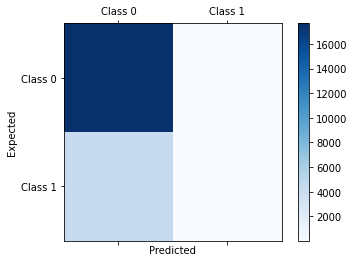

[0.0000000e+00 6.2185539e-04 1.0000000e+00] [0.         0.00339674 1.        ] [2 1 0]


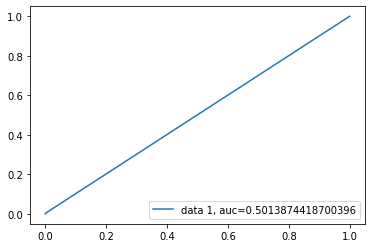

In [ ]:
model(X1, y1, XGBClassifier, "random under-sampling", ['v1', "random under-sampling" ])

Accuracy: 80.03%
 f1  0.00540662311331381 
 recall 0.002717391304347826 
 precision 0.5217391304347826
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-37
Confusion matrix:
 [[17678    11]
 [ 4404    12]]


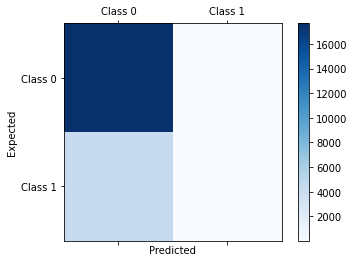

[0.0000000e+00 6.2185539e-04 1.0000000e+00] [0.         0.00271739 1.        ] [2 1 0]


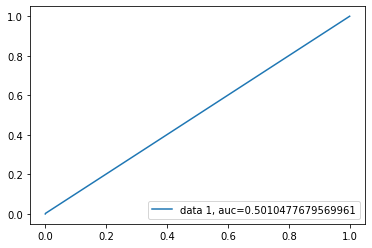

In [ ]:
model(X2, y2, XGBClassifier, "random under-sampling", ['v2', "random under-sampling" ])

random over-sampling

In [ ]:
from imblearn.over_sampling import RandomOverSampler

In [ ]:
ros = RandomOverSampler()
X_ros1, y_ros1 = ros.fit_sample(X1, y1)
X_ros2, y_ros2 = ros.fit_sample(X2, y2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 68.55%
 f1  0.728832197053002 
 recall 0.8442595108695652 
 precision 0.6411711595511415
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-38
Confusion matrix:
 [[ 9273  8346]
 [ 2751 14913]]


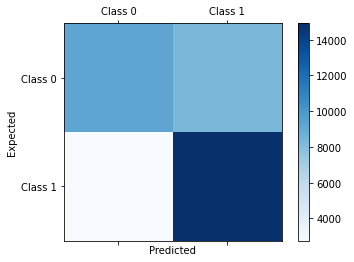

[0.         0.47369317 1.        ] [0.         0.84425951 1.        ] [2 1 0]


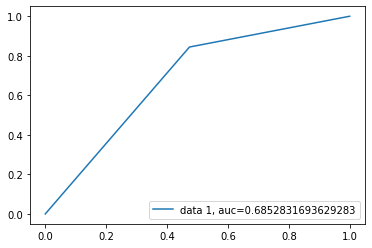

In [ ]:
model(X_ros1, y_ros1, XGBClassifier, "random over-sampling", ['v1', "random over-sampling" ])

Accuracy: 68.51%
 f1  0.7296527896055865 
 recall 0.8488451086956522 
 precision 0.6398122466396415
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-39
Confusion matrix:
 [[ 9178  8441]
 [ 2670 14994]]


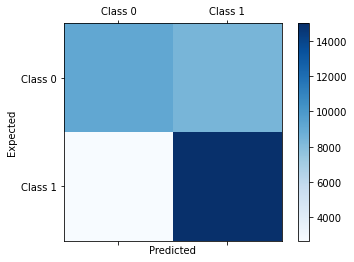

[0.         0.47908508 1.        ] [0.         0.84884511 1.        ] [2 1 0]


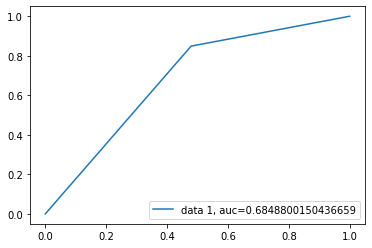

In [ ]:
model(X_ros2, y_ros2, XGBClassifier, "random over-sampling", ['v2', "random over-sampling" ])

SMOTE&Tomek

In [ ]:
smote_tomek = SMOTETomek(random_state=0)
X_stomek1, y_stomek1 = smote_tomek.fit_resample(X1, y1)
X_stomek2, y_stomek2 = smote_tomek.fit_resample(X2, y2)


/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Accuracy: 82.47%
 f1  0.8215514215514215 
 recall 0.810232622542232 
 precision 0.8331909440410081
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-40
Confusion matrix:
 [[12211  2343]
 [ 2741 11703]]


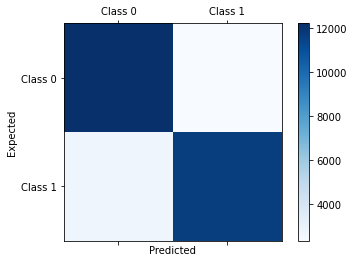

[0.         0.16098667 1.        ] [0.         0.81023262 1.        ] [2 1 0]


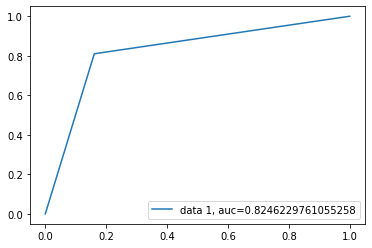

In [ ]:
model(X_stomek1, y_stomek1, XGBClassifier, "SMOTETomek", ['v1', "SMOTETomek" ])

Accuracy: 86.47%
 f1  0.8563894077573893 
 recall 0.810748959778086 
 precision 0.9074749670107894
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-41
Confusion matrix:
 [[13372  1192]
 [ 2729 11691]]


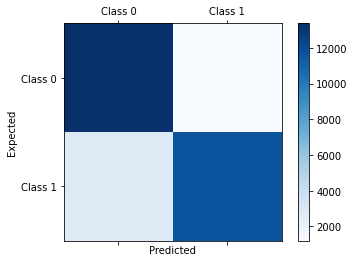

[0.         0.08184565 1.        ] [0.         0.81074896 1.        ] [2 1 0]


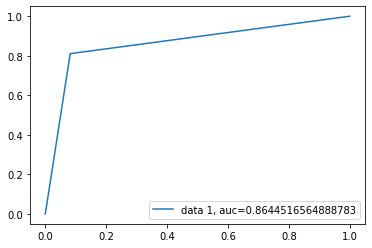

In [ ]:
model(X_stomek2, y_stomek2, XGBClassifier, "SMOTETomek", ['v2', "SMOTETomek" ])

Nearmiss

In [ ]:
from imblearn.under_sampling import NearMiss

In [ ]:
nm = NearMiss()
X_nm1, y_nm1 = nm.fit_resample(X1, y1)
X_nm2, y_nm2 = nm.fit_resample(X2, y2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarni

Accuracy: 77.88%
 f1  0.7737276478679505 
 recall 0.7587679856115108 
 precision 0.789289055191768
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-42
Confusion matrix:
 [[3577  901]
 [1073 3375]]


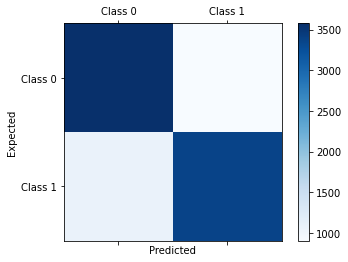

[0.        0.2012059 1.       ] [0.         0.75876799 1.        ] [2 1 0]


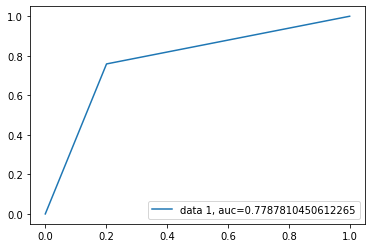

In [ ]:
model(X_nm1, y_nm1, XGBClassifier, "Nearmiss", ['v1', "Nearmiss" ])

Accuracy: 77.77%
 f1  0.7725292364136667 
 recall 0.7574190647482014 
 precision 0.7882545624707534
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-43
Confusion matrix:
 [[3573  905]
 [1079 3369]]


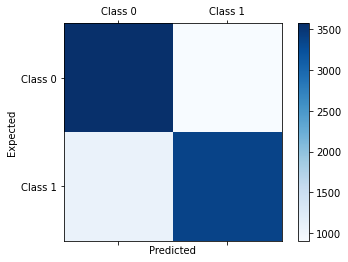

[0.         0.20209915 1.        ] [0.         0.75741906 1.        ] [2 1 0]


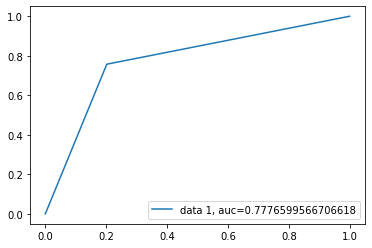

In [ ]:
model(X_nm2, y_nm2, XGBClassifier, "Nearmiss", ['v2', "Nearmiss" ])

adasyn

In [ ]:
from imblearn.over_sampling import ADASYN

In [ ]:
ada = ADASYN(random_state=42)
X_ada1, y_ada1 = ada.fit_resample(X1, y1)
X_ada2, y_ada2 = ada.fit_resample(X2, y2)

/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


Accuracy: 80.51%
 f1  0.8018665584603792 
 recall 0.7903216591441468 
 precision 0.8137537502206013
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-44
Confusion matrix:
 [[14400  3166]
 [ 3670 13833]]


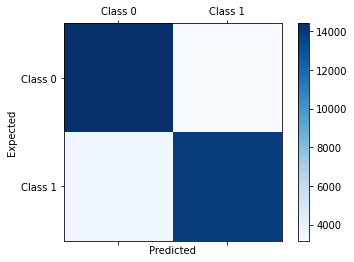

[0.         0.18023454 1.        ] [0.         0.79032166 1.        ] [2 1 0]


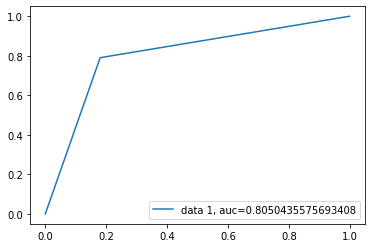

In [ ]:
model(X_ada1, y_ada1, XGBClassifier, "ADASYN", ['v1', "ADASYN" ])

Accuracy: 83.99%
 f1  0.828464923001711 
 recall 0.7785115424371195 
 precision 0.8852683818727961
https://ui.neptune.ai/DataWorkshop-Foundation/Predicting-cancellation-of-visit/e/PCV-45
Confusion matrix:
 [[15898  1757]
 [ 3857 13557]]


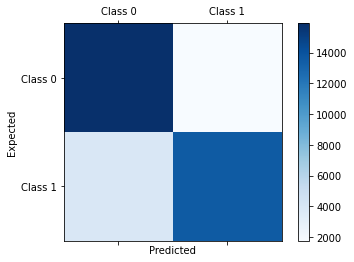

[0.         0.09951855 1.        ] [0.         0.77851154 1.        ] [2 1 0]


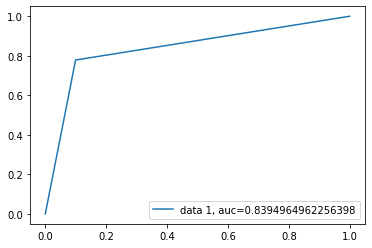

In [ ]:
model(X_ada2, y_ada2, XGBClassifier, "ADASYN", ['v2', "ADASYN" ])

Under-sampling: Cluster Centroids

In [ ]:
#from imblearn.under_sampling import ClusterCentroids 

In [ ]:
#cc = ClusterCentroids(random_state=42)

In [ ]:
#X_cc, y_cc = cc.fit_resample(X, y)

In [ ]:
#model(X_cc, y_cc, DecisionTreeClassifier, "Cluster Centroids", ['binaryEncoding', "Cluster Centroids"])

Bibliography:
*   http://enroute.pl/transformacja-zmiennych-kategorycznych-dummies/
*   https://www.featureranking.com/tutorials/machine-learning-tutorials/data-preparation-for-machine-learning/
*   https://kiwidamien.github.io/encoding-categorical-variables.html
*   https://towardsdatascience.com/all-about-categorical-variable-encoding-305f3361fd02

*   Binary encoding:
    https://www.datacamp.com/community/tutorials/categorical-data
*   Label encoding:
  https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.LabelEncoder.html

*   Porównanie klasyfikatorów:
https://scikit-learn.org/stable/auto_examples/classification/plot_classifier_comparison.html



https://colab.research.google.com/github/neptune-ai/neptune-colab-examples/blob/master/neptune_test_run.ipynb#scrollTo=G6hnHaoZDl9u


In [ ]:
#binaryDataset.to_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/dla Janka/binary.csv')
rus.to_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/dla Janka/randomundersamplig.csv')
ros.to_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/dla Janka/randomoversampling.csv')
smote_tomek.to_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/dla Janka/smotetomek.csv')
nm.to_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/dla Janka/nearmiss.csv')
ada.to_csv('/content/drive/My Drive/Colab Notebooks/Cancellation/data/dla Janka/adasyn.csv')



AttributeError: ignored